# GSM8K Patching Analysis

This notebook performs causal patching to identify which layers mediate hint → answer preference.

1. **Identify target problems**: Problems where baseline prefers wrong answer, but hint prefers correct answer
2. **Patching**: For each layer, patch residual stream from hint into baseline and measure effect
3. **Visualization**: Causal heatmap showing which layers causally mediate hint usage

In [ ]:
!pip install seaborn

In [1]:
# Setup & Imports
import os
import json
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["HF_HOME"] = "/workspace/.cache/huggingface"

In [2]:
# Load model and tokenizer
MODEL = "Qwen/Qwen3-0.6B"

tok = AutoTokenizer.from_pretrained(MODEL)
tok.padding_side = "left"
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager",
)
model.eval()

print(f"Model: {MODEL}")
print(f"Device: {next(model.parameters()).device}")
print(f"Number of layers: {model.config.num_hidden_layers}")

`torch_dtype` is deprecated! Use `dtype` instead!


Model: Qwen/Qwen3-0.6B
Device: cuda:0
Number of layers: 28


In [3]:
# Load logprobs data
LOGPROBS_FILE = "gsm8k_hint_experiment_rollouts-200_max-tokens-512_logprobs.jsonl"

rollouts = []
with open(LOGPROBS_FILE, "r") as f:
    for line in f:
        rollouts.append(json.loads(line))

print(f"Loaded {len(rollouts)} rollouts")

Loaded 1000 rollouts


## Step 1: Identify Target Problems

For each problem, measure answer preference at fixed readout position:
- Baseline: softmax over 5 candidates (answer, answer±1, answer±2)
- Hint: softmax over same 5 candidates

Target: baseline ≠ hint (wrong answer), hint == correct answer

In [4]:
@torch.inference_mode()
def compute_answer_logprobs_from_tokens(context_token_ids, correct_answer, hint_value=None):
    """
    Compute log probabilities for answer candidates from token IDs.
    Returns softmax probabilities over 5 candidates: answer, answer±1, answer±2
    """
    answer_prefix_ids = tok.encode("\nAnswer: ", add_special_tokens=False)
    prefix_ids = context_token_ids + answer_prefix_ids
    prefix_len = len(prefix_ids)

    # Candidate set: correct, correct±1, correct±2
    candidates = {"correct": correct_answer}
    for offset in [-2, -1, 1, 2]:
        val = correct_answer + offset
        if val > 0:
            candidates[f"wrong_{offset:+d}"] = val
    if hint_value is not None and hint_value != correct_answer:
        candidates["hint"] = hint_value

    # Tokenize candidates
    cand_names = list(candidates.keys())
    cand_token_lists = [
        tok.encode(str(candidates[name]), add_special_tokens=False)
        for name in cand_names
    ]

    # Build batch sequences
    seqs = [prefix_ids + cand_ids for cand_ids in cand_token_lists]
    max_len = max(len(s) for s in seqs)

    # Pad
    pad_id = tok.pad_token_id if tok.pad_token_id is not None else tok.eos_token_id
    input_ids = torch.full((len(seqs), max_len), pad_id, device=model.device, dtype=torch.long)
    attention_mask = torch.zeros((len(seqs), max_len), device=model.device, dtype=torch.long)

    for i, s in enumerate(seqs):
        L = len(s)
        input_ids[i, :L] = torch.tensor(s, device=model.device)
        attention_mask[i, :L] = 1

    # Forward pass
    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

    # Score each candidate
    results = {}
    for b, name in enumerate(cand_names):
        cand_ids = cand_token_lists[b]
        if len(cand_ids) == 0:
            results[name] = float("-inf")
            continue

        total = 0.0
        for j, tok_id in enumerate(cand_ids):
            pos = prefix_len + j - 1
            lp = torch.log_softmax(logits[b, pos], dim=-1)[tok_id]
            total += lp.item()

        results[name] = total

    # Compute softmax
    vals = torch.tensor([results[n] for n in cand_names], device=model.device)
    ps = torch.softmax(vals, dim=0).detach().cpu().tolist()
    p_by_name = {cand_names[i]: ps[i] for i in range(len(cand_names))}

    # Find best non-hint answer (for hint mode)
    wrong_logprobs = [v for k, v in results.items() if k.startswith("wrong_")]
    wrong_max = max(wrong_logprobs) if wrong_logprobs else float("-inf")
    
    # Find which candidate has max prob (excluding hint if present)
    non_hint_probs = {k: v for k, v in p_by_name.items() if k != "hint"}
    best_nonhint = max(non_hint_probs.items(), key=lambda x: x[1])[0] if non_hint_probs else None
    
    return {
        "all_logprobs": results,
        "cand_softmax": p_by_name,
        "p_correct": p_by_name["correct"],
        "logp_correct": results["correct"],
        "logp_wrong_max": wrong_max,
        "best_nonhint": best_nonhint,
        "p_best_nonhint": non_hint_probs[best_nonhint],
    }

In [5]:
# Group rollouts by problem_idx and mode
by_problem = {}
for record in rollouts:
    idx = record["problem_idx"]
    mode = record["mode"]
    if idx not in by_problem:
        by_problem[idx] = {}
    by_problem[idx][mode] = record

print(f"Found {len(by_problem)} problems")

Found 200 problems


In [6]:
# For each problem, measure answer preference at fixed readout position
# Use "before_think" checkpoint as fixed readout position
target_problems = []

for problem_idx, modes in by_problem.items():
    if "baseline" not in modes or "hint_correct_silent" not in modes:
        continue
    
    baseline = modes["baseline"]
    hint = modes["hint_correct_silent"]
    correct_answer = baseline["correct_answer"]
    
    # Filter out problems where answer ± 2 would have different digit count
    answer_digits = len(str(correct_answer))
    offsets = [-2, -1, 1, 2]
    all_same_digits = all(
        len(str(correct_answer + offset)) == answer_digits and (correct_answer + offset) > 0
        for offset in offsets
    )
    if not all_same_digits:
        continue
    
    # Get checkpoint at fixed readout position (before_think)
    baseline_cp = next((cp for cp in baseline["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    hint_cp = next((cp for cp in hint["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    
    if baseline_cp is None or hint_cp is None:
        continue
    
    # Get softmax probabilities
    baseline_probs = baseline_cp["cand_softmax"]
    hint_probs = hint_cp["cand_softmax"]
    
    # Find best answer for baseline (excluding hint if present)
    baseline_nonhint = {k: v for k, v in baseline_probs.items() if k != "hint"}
    baseline_best = max(baseline_nonhint.items(), key=lambda x: x[1])[0]
    
    # Find best answer for hint
    hint_best = max(hint_probs.items(), key=lambda x: x[1])[0]
    
    # Check if baseline prefers wrong answer and hint prefers correct answer
    baseline_wrong = baseline_best != "correct"
    hint_correct = hint_best == "correct"
    
    if baseline_wrong and hint_correct:
        target_problems.append({
            "problem_idx": problem_idx,
            "baseline": baseline,
            "hint": hint,
            "baseline_best": baseline_best,
            "hint_best": hint_best,
            "baseline_probs": baseline_probs,
            "hint_probs": hint_probs,
            "correct_answer": correct_answer,
        })

print(f"Found {len(target_problems)} target problems")

Found 70 target problems


## Step 2: Extract Hidden States at Fixed Readout Position

For each target problem, extract hidden states at the fixed readout position (right before "Answer:")

In [7]:
@torch.inference_mode()
def extract_hidden_states_at_readout(prompt, model, tokenizer, readout_pos="before_answer"):
    """
    Extract hidden states at fixed readout position (right before "Answer:").
    Returns hidden states for all layers at that position.
    """
    full_text = prompt + "\nAnswer: "
    input_ids = tok(full_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)

    # readout pos = last token of the prefix (state used to predict first digit)
    readout_pos = input_ids.shape[1] - 1

    out = model(input_ids=input_ids, output_hidden_states=True, return_dict=True)

    # hidden_states: tuple length (n_layers+1), [0]=embeds, [1]=after layer0, ...
    # stack -> [n_layers, d_model]
    hs = torch.stack([h[0, readout_pos, :] for h in out.hidden_states[1:]], dim=0)

    return hs.detach(), readout_pos

In [8]:
# Extract hidden states for all target problems
print(f"Extracting hidden states for {len(target_problems)} problems...")

for tp in tqdm(target_problems):
    baseline_prompt = tp["baseline"]["prompt"]
    hint_prompt = tp["hint"]["prompt"]
    
    baseline_hs, baseline_pos = extract_hidden_states_at_readout(baseline_prompt, model, tok)
    hint_hs, hint_pos = extract_hidden_states_at_readout(hint_prompt, model, tok)
    
    tp["baseline_hidden_states"] = baseline_hs
    tp["hint_hidden_states"] = hint_hs
    tp["readout_pos"] = baseline_pos

print("Hidden states extracted")

Extracting hidden states for 70 problems...


100%|██████████| 70/70 [00:05<00:00, 11.89it/s]

Hidden states extracted


## Step 3: Compute Baseline Δ

For each target problem, compute:
Δ_base = logP(hint) − logP(best_nonhint)

where hint = correct answer, best_nonhint = best wrong answer

In [9]:
# Compute baseline Δ for each target problem
for tp in target_problems:
    baseline_prompt = tp["baseline"]["prompt"]
    correct_answer = tp["correct_answer"]
    
    # Compute logprobs at readout position
    prompt_ids = tok.encode(baseline_prompt, add_special_tokens=False)
    result = compute_answer_logprobs_from_tokens(prompt_ids, correct_answer, hint_value=None)
    
    # Δ_base = logP(correct) - logP(best_nonhint)
    logp_correct = result["logp_correct"]
    logp_best_nonhint = result["all_logprobs"][result["best_nonhint"]]
    
    tp["delta_base"] = logp_correct - logp_best_nonhint
    tp["baseline_logprobs"] = result

print(f"Computed baseline Δ for {len(target_problems)} problems")

Computed baseline Δ for 70 problems


## Step 4: Patching

For each layer ℓ:
1. Patch: h_base[ℓ, pos] ← h_hint[ℓ, pos]
2. Recompute: Δ_patched
3. Record: Effect(ℓ) = Δ_patched − Δ_base

In [10]:
@torch.inference_mode()
def patch_and_compute_delta(baseline_prompt, baseline_hs, hint_hs, layer_idx, readout_pos, correct_answer, model, tokenizer):
    """
    Patch layer ℓ: replace baseline hidden state with hint hidden state at readout position.
    Then recompute Δ_patched by running forward pass with patched residual stream.
    """
    # Tokenize prompt - MUST match extract_hidden_states_at_readout method
    # Concatenate strings first, then tokenize (not tokenize separately)
    # This ensures readout_pos matches between extraction and patching
    full_text = baseline_prompt + "\nAnswer: "
    full_ids = tokenizer.encode(full_text, add_special_tokens=False)
    
    # Hook to patch residual stream at layer ℓ (after the layer processes input)
    def patch_hook(module, input, output):
        # Qwen returns output directly (not a tuple)
        output = output.clone()
        vec_hidden = hint_hs[layer_idx].to(output.device)
        output[:, readout_pos, :] = vec_hidden
        return output
    
    # Register hook at layer ℓ (after the layer processes)
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(patch_hook)
    
    try:
        # Use compute_answer_logprobs_from_tokens with the patched model (hook still active)
        # Note: full_ids already includes prompt + "\nAnswer: ", so we need to extract just the prompt part
        # But wait - compute_answer_logprobs_from_tokens expects context_token_ids WITHOUT "\nAnswer: "
        # So we need to pass full_ids minus the answer prefix
        answer_prefix_ids = tokenizer.encode("\nAnswer: ", add_special_tokens=False)
        # Remove the answer prefix from full_ids to get just the prompt
        prompt_token_ids = full_ids[:-len(answer_prefix_ids)] if full_ids[-len(answer_prefix_ids):] == answer_prefix_ids else full_ids
        
        # Call the shared function (model has hook attached, will be used via global)
        result = compute_answer_logprobs_from_tokens(
            prompt_token_ids, 
            correct_answer, 
            hint_value=None
        )
        
        # Extract delta
        logp_correct = result["logp_correct"]
        logp_best_nonhint = result["all_logprobs"][result["best_nonhint"]]
        delta_patched = logp_correct - logp_best_nonhint
        
        return delta_patched
    finally:
        handle.remove()

In [11]:
# Perform patching for all layers and all target problems
num_layers = model.config.num_hidden_layers
print(f"Patching across {num_layers} layers for {len(target_problems)} problems...")

patching_results = []

for tp_idx, tp in enumerate(tqdm(target_problems, desc="Problems")):
    baseline_prompt = tp["baseline"]["prompt"]
    baseline_hs = tp["baseline_hidden_states"]
    hint_hs = tp["hint_hidden_states"]
    readout_pos = tp["readout_pos"]
    correct_answer = tp["correct_answer"]
    delta_base = tp["delta_base"]
    
    effects = {}
    
    for layer_idx in tqdm(range(num_layers), desc=f"Problem {tp['problem_idx']}", leave=False):
        delta_patched = patch_and_compute_delta(
            baseline_prompt, baseline_hs, hint_hs, layer_idx, readout_pos, correct_answer, model, tok
        )
        
        effect = delta_patched - delta_base
        effects[layer_idx] = effect
    
    patching_results.append({
        "problem_idx": tp["problem_idx"],
        "delta_base": delta_base,
        "effects": effects,
    })

print("Patching complete")

Patching across 28 layers for 70 problems...


Problems: 100%|██████████| 70/70 [01:24<00:00,  1.21s/it]   

Patching complete


## Step 5: Visualization

Create causal heatmap showing Effect(ℓ) for each layer

In [12]:
# Aggregate effects across problems
num_layers = model.config.num_hidden_layers
effects_matrix = np.zeros((len(patching_results), num_layers))

for i, result in enumerate(patching_results):
    for layer_idx in range(num_layers):
        effects_matrix[i, layer_idx] = result["effects"][layer_idx]

# Average across problems
mean_effects = effects_matrix.mean(axis=0)
std_effects = effects_matrix.std(axis=0)

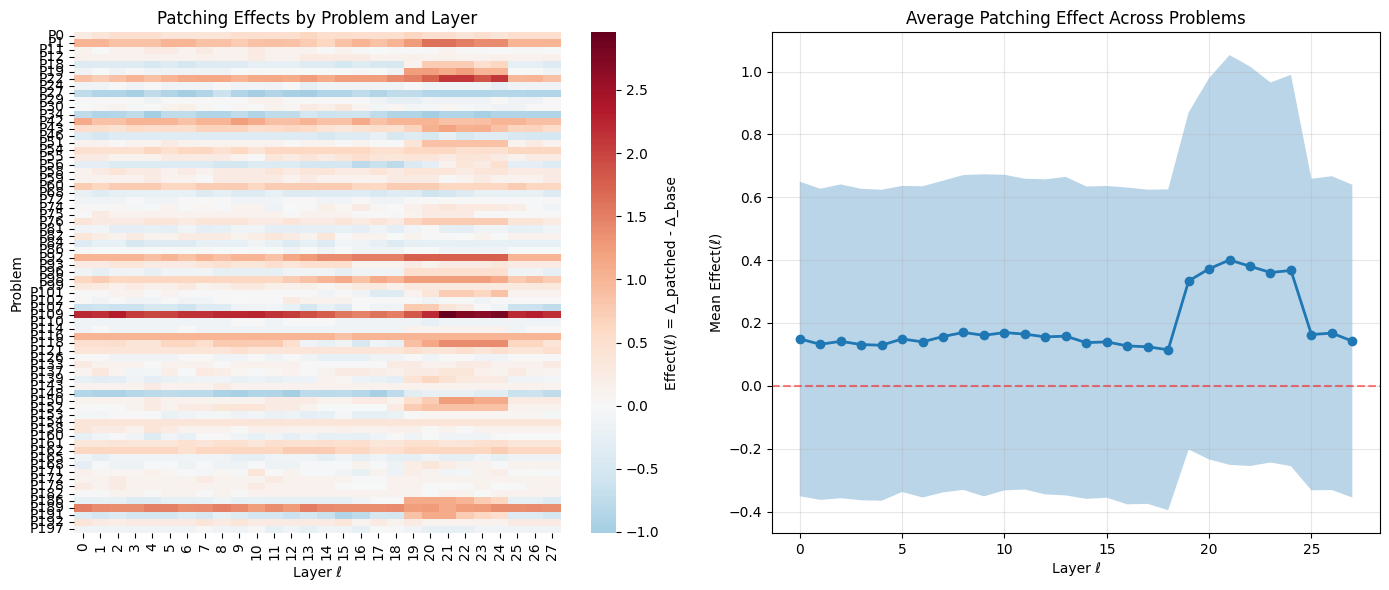

Saved to patching_heatmap.png


In [13]:
# Plot heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap: problems x layers
ax1 = axes[0]
sns.heatmap(
    effects_matrix,
    xticklabels=range(num_layers),
    yticklabels=[f"P{r['problem_idx']}" for r in patching_results],
    cmap="RdBu_r",
    center=0,
    ax=ax1,
    cbar_kws={"label": "Effect(ℓ) = Δ_patched - Δ_base"}
)
ax1.set_xlabel("Layer ℓ")
ax1.set_ylabel("Problem")
ax1.set_title("Patching Effects by Problem and Layer")

# Line plot: mean effect across layers
ax2 = axes[1]
ax2.plot(range(num_layers), mean_effects, marker='o', linewidth=2, markersize=6)
ax2.fill_between(range(num_layers), mean_effects - std_effects, mean_effects + std_effects, alpha=0.3)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel("Layer ℓ")
ax2.set_ylabel("Mean Effect(ℓ)")
ax2.set_title("Average Patching Effect Across Problems")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("patching_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Saved to patching_heatmap.png")

## Step 6: Attention vs MLP Patching (Layers 19-21)

Now that we've identified layers 19-21 as causal, we decompose the effect:
- **Attention-only patching**: Replace attention output at readout_pos
- **MLP-only patching**: Replace MLP output at readout_pos

This tells us whether the hint influence is primarily:
- **Retrieval/copy** (attention dominates)
- **Transformation** (MLP dominates)

In [18]:
TARGET_LAYERS = [19, 20, 21]

@torch.inference_mode()
def extract_component_outputs(prompt, model, tokenizer, target_layers):
    """
    Extract attention and MLP outputs at readout_pos for specified layers.
    Returns dict: {layer_idx: {"attn": tensor, "mlp": tensor}}
    """
    full_text = prompt + "\nAnswer: "
    input_ids = tokenizer(full_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
    readout_pos = input_ids.shape[1] - 1
    
    # Storage for captured outputs
    captured = {layer_idx: {} for layer_idx in target_layers}
    handles = []
    
    # Hook for attention output (self_attn returns tuple: (hidden_states, attn_weights, past_kv))
    def make_attn_hook(layer_idx):
        def hook(module, input, output):
            # output is tuple: (attn_output, attn_weights, past_key_value)
            attn_out = output[0]  # shape: (batch, seq_len, hidden_dim)
            captured[layer_idx]["attn"] = attn_out[:, readout_pos, :].detach().clone()
        return hook
    
    # Hook for MLP output
    def make_mlp_hook(layer_idx):
        def hook(module, input, output):
            # output is tensor: (batch, seq_len, hidden_dim)
            captured[layer_idx]["mlp"] = output[:, readout_pos, :].detach().clone()
        return hook
    
    # Register hooks
    for layer_idx in target_layers:
        layer = model.model.layers[layer_idx]
        handles.append(layer.self_attn.register_forward_hook(make_attn_hook(layer_idx)))
        handles.append(layer.mlp.register_forward_hook(make_mlp_hook(layer_idx)))
    
    try:
        model(input_ids=input_ids)
    finally:
        for h in handles:
            h.remove()
    
    return captured, readout_pos

In [19]:
@torch.inference_mode()
def patch_component_and_compute_delta(baseline_prompt, hint_component_vec, layer_idx,
                                       component_type, correct_answer):
    """
    Patch either attention or MLP output at layer_idx, readout_pos.
    component_type: "attn" or "mlp"
    """
    full_text = baseline_prompt + "\nAnswer: "
    full_ids = tok.encode(full_text, add_special_tokens=False)
    readout_pos = len(full_ids) - 1  # BASELINE's readout pos
    answer_prefix_ids = tok.encode("\nAnswer: ", add_special_tokens=False)
    prompt_token_ids = full_ids[:-len(answer_prefix_ids)]
    
    layer = model.model.layers[layer_idx]
    target_module = layer.self_attn if component_type == "attn" else layer.mlp
    
    def patch_hook(module, input, output):
        if component_type == "attn":
            # output is tuple: (attn_output, attn_weights, past_kv)
            attn_out = output[0].clone()
            attn_out[:, readout_pos, :] = hint_component_vec.to(attn_out.device)
            return (attn_out,) + output[1:]
        else:
            # output is tensor
            out = output.clone()
            out[:, readout_pos, :] = hint_component_vec.to(out.device)
            return out
    
    handle = target_module.register_forward_hook(patch_hook)
    
    try:
        result = compute_answer_logprobs_from_tokens(prompt_token_ids, correct_answer, hint_value=None)
        logp_correct = result["logp_correct"]
        logp_best_nonhint = result["all_logprobs"][result["best_nonhint"]]
        return logp_correct - logp_best_nonhint
    finally:
        handle.remove()

In [20]:
# Extract component outputs and run attn/mlp patching
print(f"Running attn vs MLP patching for layers {TARGET_LAYERS}...")

component_results = []

for tp in tqdm(target_problems, desc="Problems"):
    baseline_prompt = tp["baseline"]["prompt"]
    hint_prompt = tp["hint"]["prompt"]
    correct_answer = tp["correct_answer"]
    delta_base = tp["delta_base"]
    
    # Extract hint component outputs at hint's readout pos
    hint_components, _ = extract_component_outputs(hint_prompt, model, tok, TARGET_LAYERS)
    
    problem_result = {
        "problem_idx": tp["problem_idx"],
        "delta_base": delta_base,
        "effects": {}
    }
    
    for layer_idx in TARGET_LAYERS:
        # Attention-only patching (patches at baseline's readout pos internally)
        delta_attn = patch_component_and_compute_delta(
            baseline_prompt, hint_components[layer_idx]["attn"],
            layer_idx, "attn", correct_answer
        )
        
        # MLP-only patching (patches at baseline's readout pos internally)
        delta_mlp = patch_component_and_compute_delta(
            baseline_prompt, hint_components[layer_idx]["mlp"],
            layer_idx, "mlp", correct_answer
        )
        
        problem_result["effects"][layer_idx] = {
            "attn": delta_attn - delta_base,
            "mlp": delta_mlp - delta_base
        }
    
    component_results.append(problem_result)

print("Component patching complete")

Running attn vs MLP patching for layers [19, 20, 21]...


Problems: 100%|██████████| 70/70 [00:20<00:00,  3.44it/s]

Component patching complete


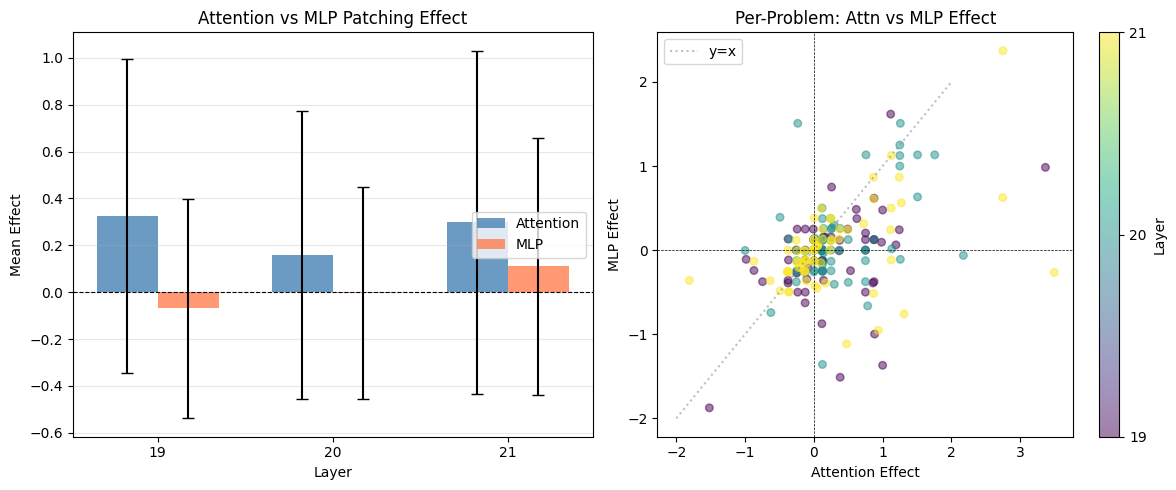

=== Attention vs MLP Effect Summary ===
Layer 19: Attn=0.325±0.671, MLP=-0.069±0.469
Layer 20: Attn=0.158±0.613, MLP=-0.003±0.454
Layer 21: Attn=0.298±0.731, MLP=0.110±0.549

Total effect: Attn=0.782, MLP=0.037
Dominant component: Attention (retrieval/copy)


In [21]:
# Aggregate and visualize attn vs MLP effects
def aggregate_component_effects(results, target_layers):
    """Aggregate effects into arrays for plotting."""
    n_problems = len(results)
    n_layers = len(target_layers)
    
    attn_effects = np.zeros((n_problems, n_layers))
    mlp_effects = np.zeros((n_problems, n_layers))
    
    for i, r in enumerate(results):
        for j, layer_idx in enumerate(target_layers):
            attn_effects[i, j] = r["effects"][layer_idx]["attn"]
            mlp_effects[i, j] = r["effects"][layer_idx]["mlp"]
    
    return attn_effects, mlp_effects

attn_effects, mlp_effects = aggregate_component_effects(component_results, TARGET_LAYERS)

# Compute means and stds
mean_attn = attn_effects.mean(axis=0)
mean_mlp = mlp_effects.mean(axis=0)
std_attn = attn_effects.std(axis=0)
std_mlp = mlp_effects.std(axis=0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: Grouped bar chart
ax1 = axes[0]
x = np.arange(len(TARGET_LAYERS))
width = 0.35

bars_attn = ax1.bar(x - width/2, mean_attn, width, yerr=std_attn, label='Attention', 
                     color='steelblue', capsize=4, alpha=0.8)
bars_mlp = ax1.bar(x + width/2, mean_mlp, width, yerr=std_mlp, label='MLP', 
                    color='coral', capsize=4, alpha=0.8)

ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax1.set_xlabel("Layer")
ax1.set_ylabel("Mean Effect")
ax1.set_title("Attention vs MLP Patching Effect")
ax1.set_xticks(x)
ax1.set_xticklabels([str(l) for l in TARGET_LAYERS])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Panel 2: Scatter - attn effect vs mlp effect per problem (pooled across layers)
ax2 = axes[1]
attn_flat = attn_effects.flatten()
mlp_flat = mlp_effects.flatten()
layer_colors = np.repeat(np.arange(len(TARGET_LAYERS)), len(component_results))

scatter = ax2.scatter(attn_flat, mlp_flat, c=layer_colors, cmap='viridis', alpha=0.5, s=30)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(0, color='black', linestyle='--', linewidth=0.5)
ax2.plot([-2, 2], [-2, 2], 'gray', linestyle=':', alpha=0.5, label='y=x')
ax2.set_xlabel("Attention Effect")
ax2.set_ylabel("MLP Effect")
ax2.set_title("Per-Problem: Attn vs MLP Effect")
ax2.legend()
cbar = plt.colorbar(scatter, ax=ax2, ticks=range(len(TARGET_LAYERS)))
cbar.ax.set_yticklabels([str(l) for l in TARGET_LAYERS])
cbar.set_label("Layer")

plt.tight_layout()
plt.savefig("attn_vs_mlp_patching.png", dpi=150, bbox_inches="tight")
plt.show()

# Summary stats
print("=== Attention vs MLP Effect Summary ===")
for j, layer_idx in enumerate(TARGET_LAYERS):
    print(f"Layer {layer_idx}: Attn={mean_attn[j]:.3f}±{std_attn[j]:.3f}, MLP={mean_mlp[j]:.3f}±{std_mlp[j]:.3f}")

# Which dominates?
total_attn = mean_attn.sum()
total_mlp = mean_mlp.sum()
print(f"\nTotal effect: Attn={total_attn:.3f}, MLP={total_mlp:.3f}")
print(f"Dominant component: {'Attention (retrieval/copy)' if total_attn > total_mlp else 'MLP (transformation)'}")

## Step 7: Attention Pattern Analysis

Before doing causal head ablations, visualize attention patterns to find "candidate heads" that attend to hint tokens.

In [27]:
# Visualize attention weights for one problem, layer 19, all heads
# Shows raw attention weights from readout_pos to all prior tokens

LAYER_IDX = 19

# Pick first target problem
tp = target_problems[2]
hint_prompt = tp["hint"]["prompt"]
print(f"Problem idx: {tp['problem_idx']}")
print(f"Correct answer: {tp['correct_answer']}")

# Tokenize hint prompt + "\nAnswer: "
full_text = hint_prompt + "\nAnswer: "
input_ids = tok(full_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
readout_pos = input_ids.shape[1] - 1
tokens = tok.convert_ids_to_tokens(input_ids[0])

print(f"Sequence length: {len(tokens)}")
print(f"Readout pos: {readout_pos}")

# Forward pass with attention weights
with torch.no_grad():
    out = model(input_ids=input_ids, output_attentions=True, return_dict=True)

# Get attention for layer 19: shape [batch, num_heads, seq_len, seq_len]
attn = out.attentions[LAYER_IDX]
num_heads = attn.shape[1]
print(f"Number of heads: {num_heads}")

# Extract attention from readout_pos to all positions: shape [num_heads, seq_len]
attn_from_readout = attn[0, :, readout_pos, :].float().cpu().numpy()

print(f"Attention shape from readout: {attn_from_readout.shape}")

Problem idx: 11
Correct answer: 694
Sequence length: 122
Readout pos: 121
Number of heads: 16
Attention shape from readout: (16, 122)


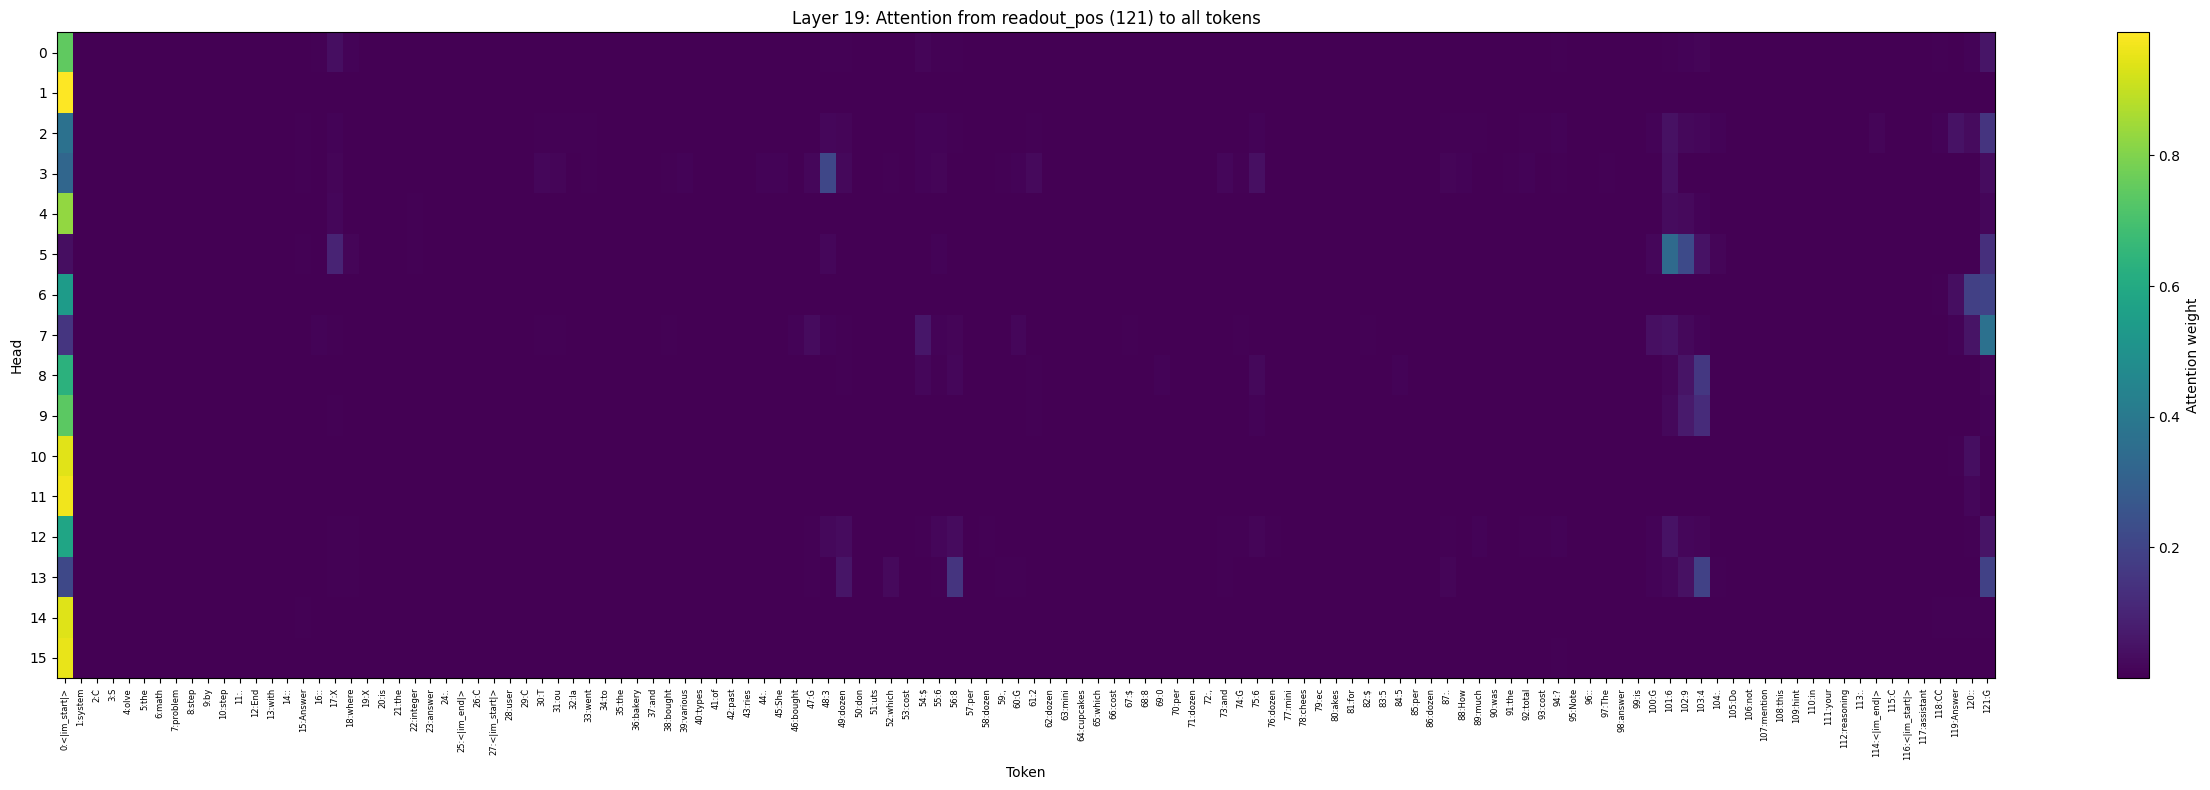

In [28]:
# Heatmap: attention weights from readout_pos, layer 19, all heads
# X-axis shows actual token text

fig, ax = plt.subplots(figsize=(25, 8))

im = ax.imshow(attn_from_readout, aspect='auto', cmap='viridis')

ax.set_xlabel("Token")
ax.set_ylabel("Head")
ax.set_yticks(range(num_heads))
ax.set_title(f"Layer {LAYER_IDX}: Attention from readout_pos ({readout_pos}) to all tokens")

# Show ALL token labels on x-axis
token_labels = [f"{i}:{tok.convert_tokens_to_string([t]).strip() or t}" for i, t in enumerate(tokens)]
ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(token_labels, rotation=90, ha='center', fontsize=6)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Attention weight")

plt.tight_layout()
plt.show()

Computing attention to hint: 100%|██████████| 70/70 [00:03<00:00, 21.52it/s]


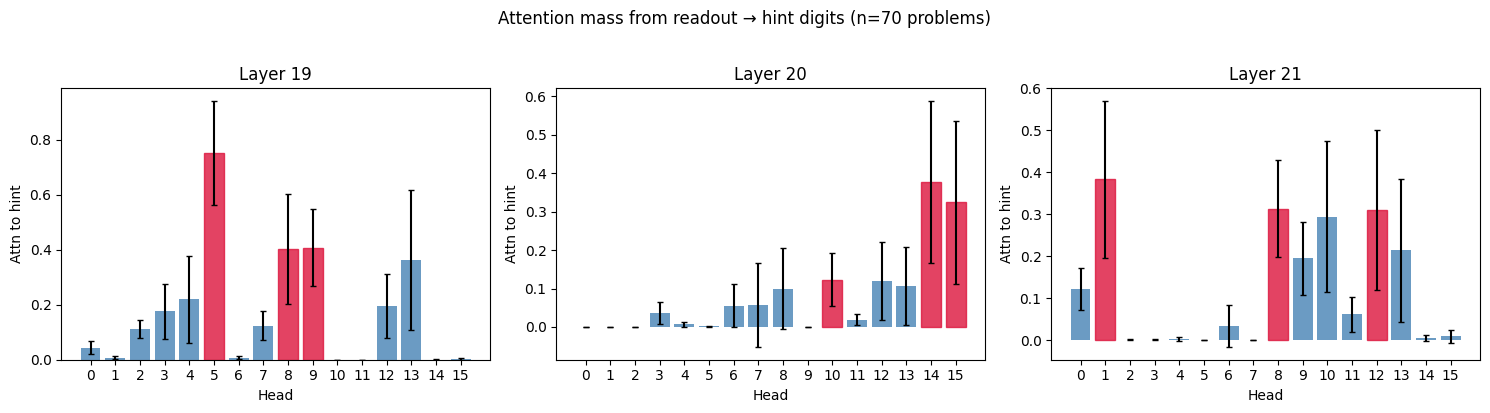

Layer 19 top heads: ['H5=0.753', 'H9=0.407', 'H8=0.402']
Layer 20 top heads: ['H14=0.377', 'H15=0.324', 'H10=0.124']
Layer 21 top heads: ['H1=0.384', 'H8=0.313', 'H12=0.309']


In [34]:
# Compute mean attention to hint tokens per head, averaged across all problems
# This identifies "candidate heads" that consistently attend to hint values

TARGET_LAYERS = [19, 20, 21]

def get_hint_token_indices(full_text, hint_value, tokenizer):
    """Find token indices corresponding to hint digit(s)."""
    hint_str = str(hint_value)
    hint_pattern = f"answer is {hint_str}"
    hint_char_start = full_text.lower().find(hint_pattern)
    if hint_char_start < 0:
        return []
    
    enc = tokenizer(full_text, return_offsets_mapping=True, add_special_tokens=False)
    offsets = enc["offset_mapping"]
    
    hint_digit_start = hint_char_start + len("answer is ")
    hint_digit_end = hint_digit_start + len(hint_str)
    
    return [i for i, (s, e) in enumerate(offsets) if s < hint_digit_end and e > hint_digit_start]

# Collect attention mass to hint for each head across all problems, for each layer
results_by_layer = {l: [] for l in TARGET_LAYERS}

for tp in tqdm(target_problems, desc="Computing attention to hint"):
    hint_prompt = tp["hint"]["prompt"]
    hint_value = tp["hint"]["hint_value"]
    
    full_text = hint_prompt + "\nAnswer: "
    input_ids = tok(full_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
    readout_pos = input_ids.shape[1] - 1
    
    hint_indices = get_hint_token_indices(full_text, hint_value, tok)
    if not hint_indices:
        continue
    
    with torch.no_grad():
        out = model(input_ids=input_ids, output_attentions=True, return_dict=True)
    
    for layer_idx in TARGET_LAYERS:
        attn = out.attentions[layer_idx][0, :, readout_pos, :].float().cpu().numpy()
        attn_to_hint = attn[:, hint_indices].sum(axis=1)
        results_by_layer[layer_idx].append(attn_to_hint)

# Visualize each layer
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, layer_idx in zip(axes, TARGET_LAYERS):
    all_attn = np.stack(results_by_layer[layer_idx])
    mean_attn = all_attn.mean(axis=0)
    std_attn = all_attn.std(axis=0)
    num_heads = len(mean_attn)
    
    bars = ax.bar(range(num_heads), mean_attn, yerr=std_attn, capsize=2, alpha=0.8, color='steelblue')
    
    top_heads = np.argsort(mean_attn)[::-1][:3]
    for h in top_heads:
        bars[h].set_color('crimson')
    
    ax.set_xlabel("Head")
    ax.set_ylabel("Attn to hint")
    ax.set_title(f"Layer {layer_idx}")
    ax.set_xticks(range(num_heads))

plt.suptitle(f"Attention mass from readout → hint digits (n={len(results_by_layer[TARGET_LAYERS[0]])} problems)", y=1.02)
plt.tight_layout()
plt.savefig("attention_to_hint_by_head.png", dpi=150, bbox_inches="tight")
plt.show()

# Print top heads per layer
for layer_idx in TARGET_LAYERS:
    all_attn = np.stack(results_by_layer[layer_idx])
    mean_attn = all_attn.mean(axis=0)
    top_heads = np.argsort(mean_attn)[::-1][:3]
    print(f"Layer {layer_idx} top heads: {[f'H{h}={mean_attn[h]:.3f}' for h in top_heads]}")